In [3]:
import os
import sys
import mpmath as mp
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
from scipy.ndimage import gaussian_filter
from scipy.signal import argrelextrema

In [4]:
# strong coupling model
def model(a,b,h):
    np_ellippi = np.frompyfunc(mp.ellippi,2,1)
    y = (2/(np.pi*a*np.abs(h)))*mp.sqrt(a**2 - h**2)*mp.sqrt(h**2 - b**2)*np_ellippi(b**2/h**2, b**2/a**2)
    return float(np.piecewise(h,[h<=-a, -a<h<-b, -b<=h<=b, b<h<a, a<=h], [0,lambda h: y,1,lambda h: y,0]))

In [5]:
# weak coupling model
def weak_model(a,h):
    y = (2/(np.pi*a**2))*np.sqrt(a**2 - h**2) 
    return np.piecewise(h,[h<=-a, -a<h<a, a<=h], [0,lambda h: y,0])

In [6]:
# THIS IS PROBABLY A LOST CAUSE lol.  I want to fit the model to the data, but it seems
# really difficult to make a tool like curve_fit work with a model that contains functions
# from mpmath.  I haven't been able to figure out how to get rid of the resulting type
# errors.

# #loading the data output by C++ code
# data = np.loadtxt('2dym.dat')

# #fitting the model to the data to find the parameters a and b, and the covariance matrix 
#params, cov= curve_fit(model, data[:,0], data[:,1])

# #plot
# a=0.6
# b=0.17

# X = [model(a,b,h) for h in np.linspace(-1,1,50)]
# plt.plot(np.linspace(-1,1,50), X)
# plt.plot(data[:,0],data[:,1])

In [29]:
# grabbing the data generated for every value of the parameter A (~ coupling constant)
# between 3.0 and 7.0 with a 0.1 sized interval
data_dirs = [os.path.join('./data', i) for i in os.listdir('./data')]

In [8]:
# Given the directory of a data file, this function finds the value of
# the model parameters a,b
def fit_params(dir):
    #loading the data output by C++ code for a given data file
    data = np.loadtxt(dir)

    # Applying a gaussian filter to smooth the data, then taking the
    # first and second derivatives.  Looking at the extrema will allow
    # us to find the places where the data transitions from 0 to a smooth
    # function, and from a smooth function to 1
    conv1 = gaussian_filter(data[:,1], sigma=7, order=1)
    conv2 = gaussian_filter(data[:,1], sigma=5, order=2)
    maxima = argrelextrema(conv2, np.greater)[0]
    minima = argrelextrema(conv2, np.less)[0]
    minima = minima[1:len(minima)-1]
    
    # a is found with a maxima
    max = maxima[len(maxima)-1]
    
    # b is found with a minima
    min = 0
    for m in minima:
        if conv2[m] < conv2[min]:
            min = m

#   Plots to illustrate how max and min are chosen
#     for m in maxima:
#         if m==max:
#             plt.axvline(x=data[m][0], linestyle='--', color='r')
#         else:
#             plt.axvline(x=data[m][0], linestyle='--', color='b')
#     plt.plot(data[:,0], data[:,1], label='data')
#     plt.plot(data[:,0], 20*conv1, label='1st derivative')
#     plt.plot(data[:,0], 20*conv2, label='2nd derivative')
#     plt.legend()
#     plt.gca().axes.get_yaxis().set_ticks([])
#     plt.savefig('./maxima.png')
#     plt.show()

#     for m in minima:
#         if m==min:
#             plt.axvline(x=data[m][0], linestyle='--', color='g')
#         else:
#             plt.axvline(x=data[m][0], linestyle='--', color='y')
#     plt.plot(data[:,0], data[:,1], label='data')
#     plt.plot(data[:,0], 20*conv1, label='1st derivative')
#     plt.plot(data[:,0], 20*conv2, label='2nd derivative')
#     plt.legend()
#     plt.gca().axes.get_yaxis().set_ticks([])
#     plt.savefig('./minima.png')
#     plt.show()

    return data[max][0], data[min][0]

In [9]:
# lists to hold the values of model parameters a,b for each data file
As = []
Bs = []

# running the function for each data file
for i in data_dirs:
    a,b = fit_params(i)
    As.append(np.abs(a))
    Bs.append(np.abs(b))

In [16]:
# single equation we use to solve for k=b/a in the strong coupling case
def f(k,a):
    K = sp.special.ellipk(k)
    E = sp.special.ellipe(k)
    return 2*K*(2*E + (k**2 - 1)*K) - a

In [24]:
# lists to hold the exact values of a,b that can be solved for using a
# system of equations for a given A (~ coupling constant)
As_exact = []
Bs_exact = []
X = np.linspace(3.0,7.0,len(data_dirs))

for i in range(len(X)):
    # here, cc is A (~ coupling constant)
    cc = X[i]
    
    # strong coupling phase
    if cc > (np.pi**2)/2:
        
        # solves single equation f for k=b/a, then plugs k into second equation
        # to get a,b
        k = ((root(f, Bs[i]/As[i], args=cc)).x)[0]
        print(f(k,cc))
        a = 2*sp.special.ellipk(k)/cc
        As_exact.append(a)
        Bs_exact.append(k*a)
        
    # weak coupling phase
    else:
        params = [np.sqrt(2/cc),0]
        As_exact.append(params[0])
        Bs_exact.append(params[1])

-8.881784197001252e-16
0.0
-0.6311347819655717
-0.6920728435235075
0.0
-1.5987211554602254e-14
8.881784197001252e-16
-8.881784197001252e-15
-2.6645352591003757e-15
2.318145675417327e-13
1.7763568394002505e-14
1.7763568394002505e-15
1.7763568394002505e-15
0.0
0.0
0.0
-8.881784197001252e-16
-9.85878045867139e-14
-1.1723955140041653e-13
-2.220446049250313e-14
-2.1316282072803006e-14


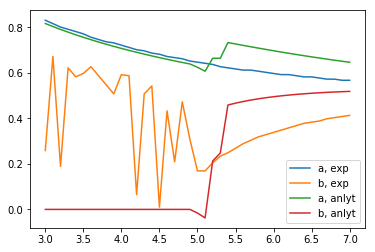

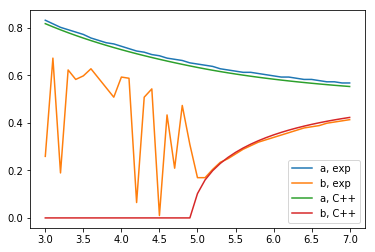

In [27]:
# plots the experimental and analytical values of a,b
#
# Notice that in the weak coupling phase, the experimental value of b is
# all over the place.  That's because when b = 0, there is no discontinuity
# in the data for the fitting function to discover, so it picks a random
# minima originating from noise.
#
# In the strong coupling phase, the analytical and experimental values of 
# a,b don't match up.  We have reason to believe the experimental ones are
# correct--when subsituted into the model, they fit the data well.  This means
# we may be incorrect about the analytical relationship between A and a,b
plt.plot(X,As, label = 'a, exp')
plt.plot(X,Bs, label = 'b, exp')
plt.plot(X, As_exact, label = 'a, anlyt')
plt.plot(X, Bs_exact, label = 'b, anlyt')
plt.legend()
plt.show()

cpp_params = np.loadtxt('./params.dat')
As_cpp = cpp_params[:,0]
Bs_cpp = cpp_params[:,1]

plt.plot(X,As, label = 'a, exp')
plt.plot(X,Bs, label = 'b, exp')
plt.plot(X, As_cpp, label = 'a, C++')
plt.plot(X, Bs_cpp, label = 'b, C++')
plt.legend()
plt.show()

In [30]:
# collecting the size of the data (to be used in plotting)
first_data = np.loadtxt(data_dirs[0])
data_length = len(first_data[:,0])
start = first_data[0,0]
end = first_data[data_length-1,0]

C:\Users\srcti\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


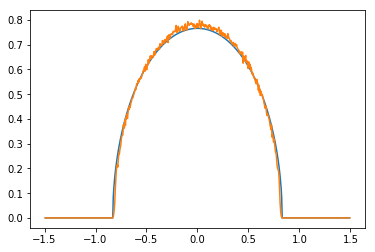

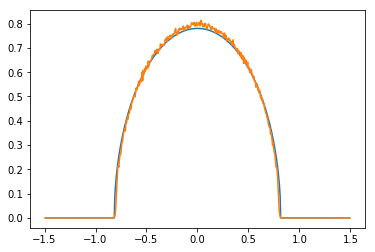

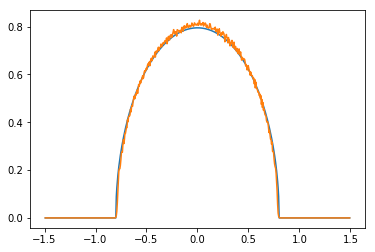

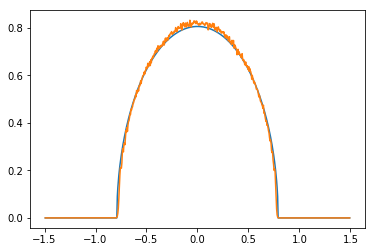

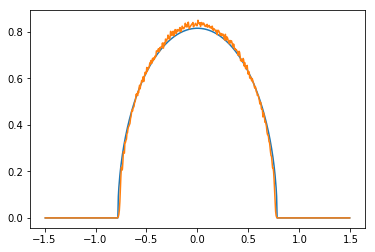

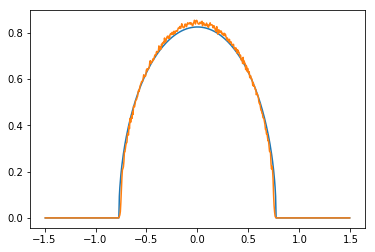

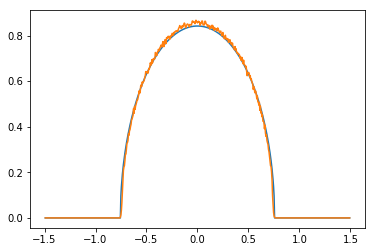

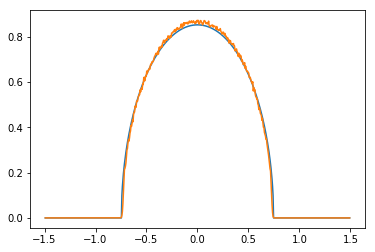

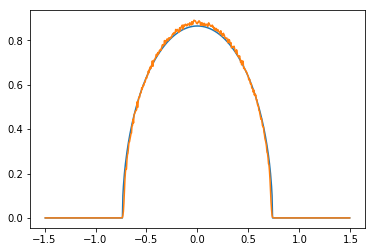

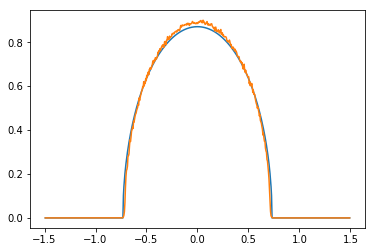

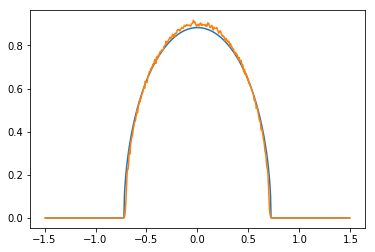

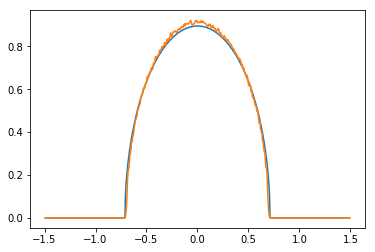

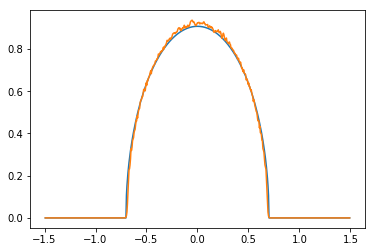

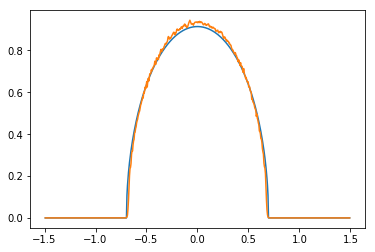

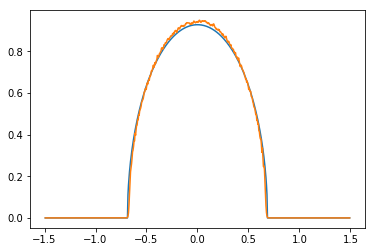

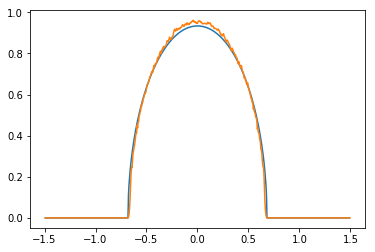

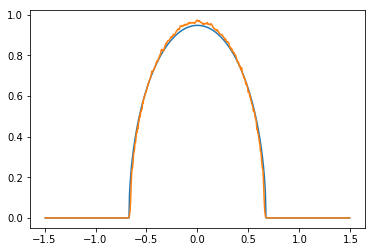

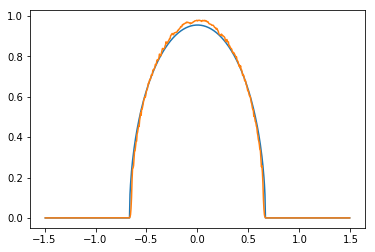

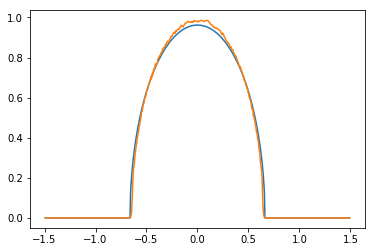

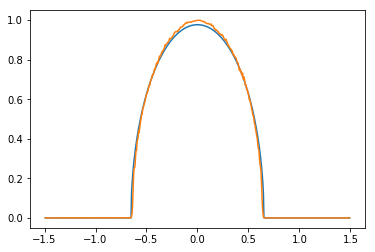

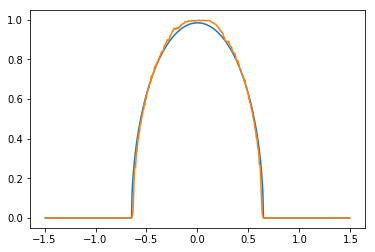

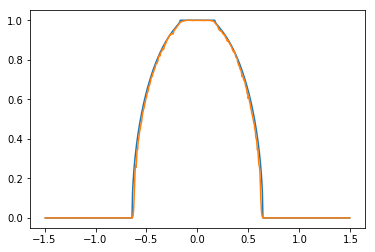

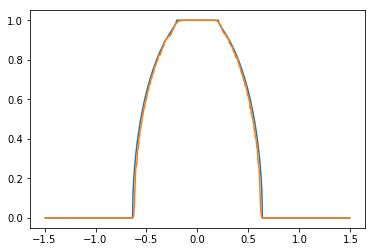

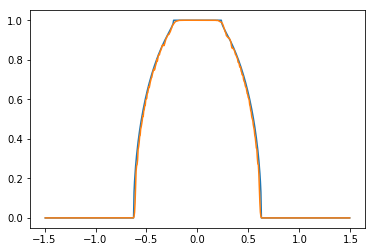

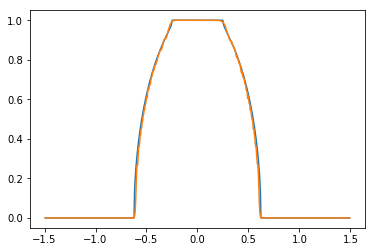

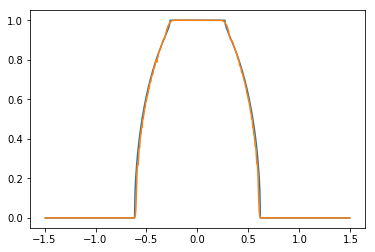

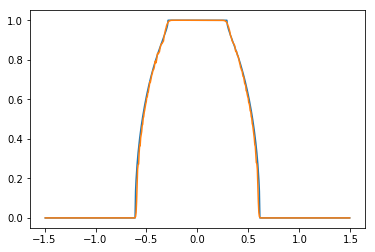

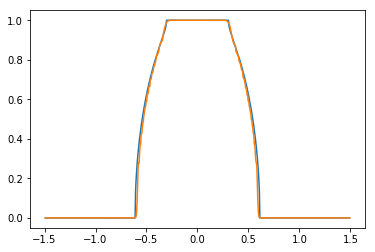

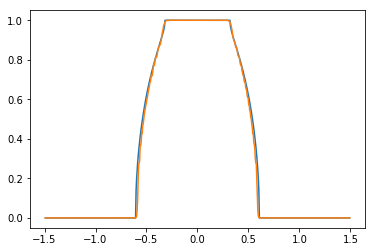

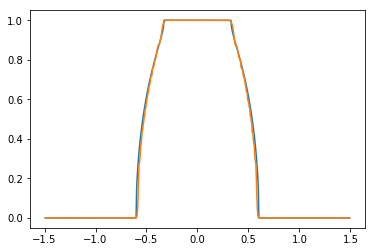

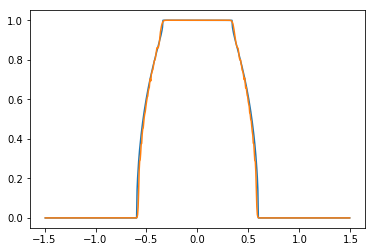

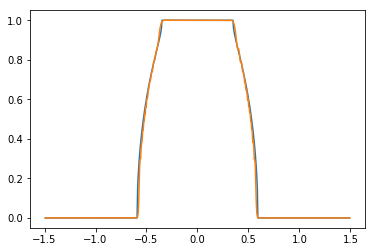

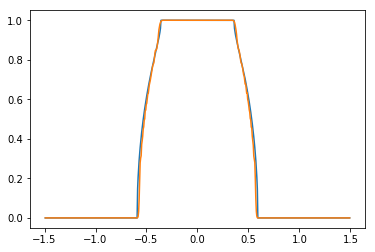

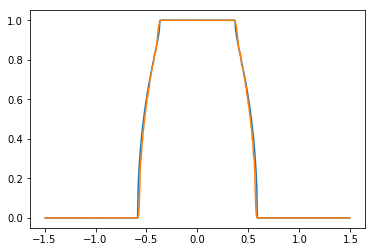

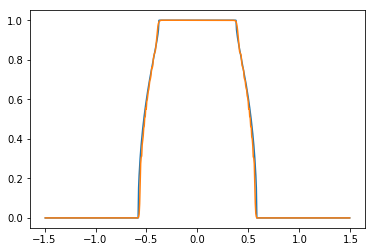

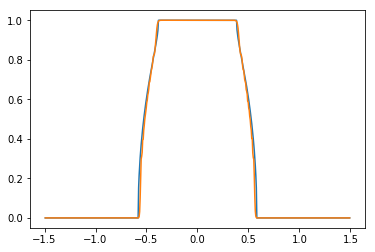

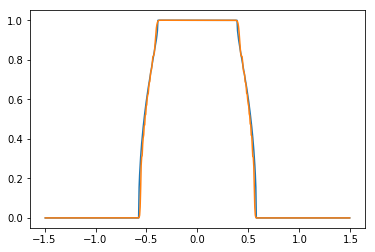

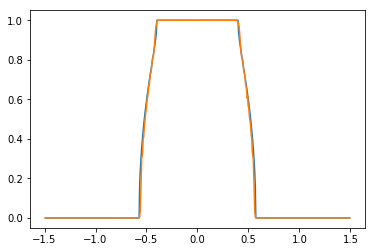

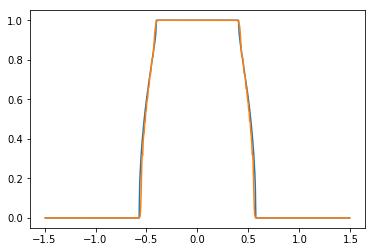

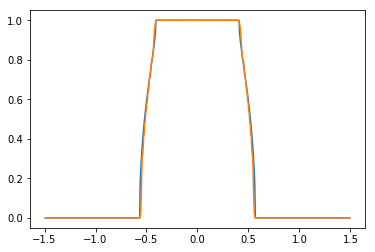

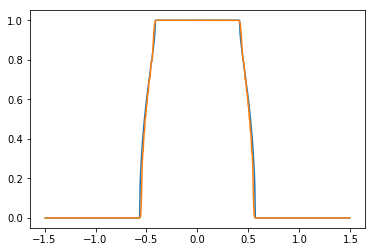

In [31]:
from scipy.stats import chi2

# for every data file, we generate a graph of the model at that value of the coupling
# constant by inputting the fit parameters
for i in range(len(X)):
    x = X[i]
    if x >= (np.pi**2)/2 + 0.1:
        pred = [model(As[i],Bs[i],h) for h in np.linspace(start,end,data_length)]
    else:
        pred = [weak_model(As[i],h) for h in np.linspace(start,end,data_length)]
    data = np.loadtxt(data_dirs[i])
    
    # plotting the predictions against the data shows visually that they are a close fit
    plt.plot(np.linspace(start,end,data_length), pred)
    plt.plot(data[:,0],data[:,1])
    plt.show()
    
    # I want to add chi-squared analysis here to prove that the model actually fits the 
    # data well, but first we need to modify the Monte Carlo simulation to give the variance
    # as well as the average configuration.

In [415]:
# loads the data computing the average value of C2 throughout the simulations
# for every A from 3.0 to 7.0 in 0.1 size increments
data_dirs_C2 = [os.path.join('./dataC2', i) for i in os.listdir('./dataC2')]
C2s = []

for dir in data_dirs_C2:
    x = np.loadtxt(dir)
    C2s.append(x)

Text(0, 0.5, '$<C2>$')

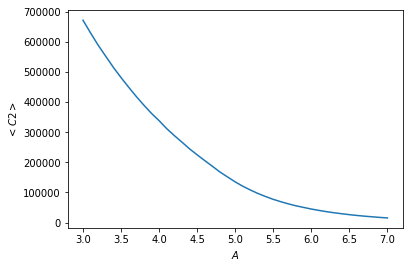

In [416]:
# plots the average value of C2 as a function of A
plt.plot(np.linspace(3.0,7.0,len(data_dirs_C2)),C2s)
plt.xlabel('$A$')
plt.ylabel('$<C2>$')

In [319]:
# creates an array of "temperatures" i.e. 1/A
temps = np.linspace(3.0,7.0,len(data_dirs_C2))
temps = np.ones(len(data_dirs_C2))/temps

In [320]:
# computes the total entropy as a function of 1/A using <C2>(T) = E(T)
def entropy(t):
    S=0
    for i in range(1,t):
        S+= (C2s[i] - C2s[i-1])**2/(temps[i]-temps[i-1])
    return S

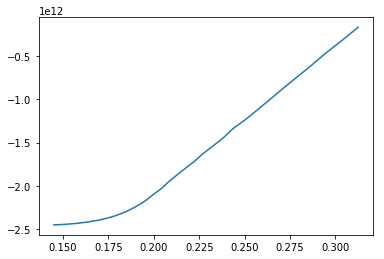

In [321]:
# plots the total entropy as a function of 1/A
Ss = [entropy(t) for t in range(2,len(C2s)-1)]
plt.plot(temps[2:(len(C2s) -1)], Ss)